___
___
___
# Light GBM
___
___
___

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

df = pd.read_csv('./data_set/SBAnational-EDA.csv')
df = df.drop(columns=['Unnamed: 0', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr'], axis=1).reset_index(drop=True)
df = df.drop(columns=['CreateJob', 'RetainedJob'], axis=1).reset_index(drop=True)
# df = df[['NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'UrbanRural', 'GrAppv', 'SBA_Appv', 'MIS_Status']]

df.columns

Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate',
       'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'FranchiseCode',
       'UrbanRural', 'RevLineCr', 'LowDoc', 'MIS_Status', 'GrAppv',
       'SBA_Appv'],
      dtype='object')

In [97]:
df.head(1).transpose()

,0
City,EVANSVILLE
State,IN
Zip,47711
Bank,FIFTH THIRD BANK
BankState,IN
NAICS,451120
ApprovalDate,1997-02-28
ApprovalFY,1997-01-01
Term,84
NoEmp,4


In [98]:
colonnes_numeriques = df.select_dtypes(include=['number']).columns.tolist()

# Sélectionner les colonnes non numériques
colonnes_non_numeriques = df.drop(columns=colonnes_numeriques).columns.tolist()

print(colonnes_numeriques, colonnes_non_numeriques)

['Zip', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv'] ['City', 'State', 'Bank', 'BankState', 'ApprovalDate', 'ApprovalFY', 'RevLineCr', 'LowDoc', 'MIS_Status']


In [99]:
# Créer un nouveau DataFrame sans les lignes contenant des valeurs NaN
# df = df.dropna()

# Vérifier s'il y a des valeurs manquantes dans le DataFrame
missing_values = df.isnull().sum()
# Afficher les colonnes avec des valeurs manquantes
print("Colonnes avec des valeurs manquantes :\n", missing_values[missing_values > 0])

# Vérifier les types de données de chaque colonne
# data_types = df.dtypes
# Afficher les types de données de chaque colonne
# print("Types de données de chaque colonne :\n", data_types)

Colonnes avec des valeurs manquantes :
 State         6
Bank         25
BankState    25
dtype: int64


In [100]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from datetime import datetime

grid_search_bool = True

numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Définir le preprocessor
label_encoder = LabelEncoder()
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), numerical_features),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary')), categorical_features),
)

# Prétraiter les données
X = preprocessor.fit_transform(df.drop(columns='MIS_Status'))
y = label_encoder.fit_transform(df['MIS_Status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)
# y_train = y_train.astype(int).tolist()
# y_test = y_test.astype(int).tolist()

if grid_search_bool == False:
    # LGBM
    d_train = lgb.Dataset(X_train, label=y_train)

    # https://lightgbm.readthedocs.io/en/latest/Parameters.html
    # pycaret
    # LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
    #                importance_type='split', learning_rate=0.1, max_depth=-1,
    #                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
    #                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
    #                random_state=0, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
    #                subsample_for_bin=200000, subsample_freq=0)

    # lgbm_params = {
    #     'objective': 'multiclass',
    #     'num_class': 4,
    #     'boosting_type': 'dart',
    #     'metric': 'multi_logloss',
    #     'num_leaves': 100,
    #     'learning_rate': 0.1,
    #     'feature_fraction': 0.8,
    #     'bagging_fraction': 0.8,
    #     'bagging_freq': 5,
    #     'verbose': 0,
    # }
    lgbm_params = {
        'objective': ['multiclass'], # binary multiclass
        'num_class': 2,
        'boosting_type': ['gbdt'], # dart goss rf
        # 'metric': ['f1'],
        'num_leaves': [100], # [10, 50, 100]
        'learning_rate': [0.2], # [0.01, 0.05, 0.1, 0.2]
        'feature_fraction': [0.8],
        'bagging_fraction': [0.8],
        'bagging_freq': [5],
        'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
        'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
        'verbose': [1],
    }
    param_grid = {
        'class_weight': [None],
        'colsample_bytree': [1.0],
        'importance_type': ['split'],
        'learning_rate': [0.1],
        'max_depth': [-1],
        'min_child_samples': [20],
        'min_child_weight': [0.001],
        'min_split_gain': [0.0],
        'n_estimators': [100],
        'n_jobs': [-1],
        'num_leaves': [31],
        'objective': [None],
        'random_state': [0],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'subsample': [1.0],
        'subsample_for_bin': [200000],
        'subsample_freq': [0],
        'metric': ['f1'],
        # 'feature_fraction': [0.8],
        # 'bagging_fraction': [0.8],
        # 'bagging_freq': [10],
        # 'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
        # 'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
        # 'verbose': [1],
    }param_grid = {
        'class_weight': [None],
        'colsample_bytree': [1.0],
        'importance_type': ['split'],
        'learning_rate': [0.1],
        'max_depth': [-1],
        'min_child_samples': [20],
        'min_child_weight': [0.001],
        'min_split_gain': [0.0],
        'n_estimators': [100],
        'n_jobs': [-1],
        'num_leaves': [31],
        'objective': [None],
        'random_state': [0],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'subsample': [1.0],
        'subsample_for_bin': [200000],
        'subsample_freq': [0],
        'metric': ['f1'],
        # 'feature_fraction': [0.8],
        # 'bagging_fraction': [0.8],
        # 'bagging_freq': [10],
        # 'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
        # 'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
        # 'verbose': [1],
    }

    start=datetime.now()
    clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates
    stop=datetime.now()
    execution_time_lgbm = stop-start

    #Prediction on test data
    y_pred_lgbm=clf.predict(X_test)

    #convert into binary values 0/1 for classification
    y_pred_lgbm = [list(x).index(max(x)) for x in y_pred_lgbm]

In [101]:
if grid_search_bool == False:
    plt.figure(figsize=(8, 6))
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    sns.heatmap(cm_lgbm, annot=True)
    plt.title("LightGBM")
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')

    ################
    #SUMMARY
    report = classification_report(y_test, y_pred_lgbm, output_dict=True)
    df_report = pd.DataFrame(report)
    print("#########################################################")
    print("     LGBM execution time is: ", execution_time_lgbm)
    print("#########################################################")
    print(df_report.T)
    print("#########################################################")
    print("                  F1 macro score:", round(report["macro avg"]["f1-score"], 4))
    print("#########################################################")

In [102]:
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm  # Importez tqdm depuis la bibliothèque tqdm.notebook

if grid_search_bool == True:
    d_train = lgb.Dataset(X_train, label=y_train)

    # Définir les paramètres à optimiser
    # pycaret
    # LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
    #                importance_type='split', learning_rate=0.1, max_depth=-1,
    #                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
    #                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
    #                random_state=0, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
    #                subsample_for_bin=200000, subsample_freq=0)
    param_grid = {
        'objective': ['binary'],
        'boosting_type': ['gbdt'], # dart goss rf
        'metric': ['f1'],
        'num_leaves': [100], # [10, 50, 100]
        'learning_rate': [0.2], # [0.01, 0.05, 0.1, 0.2]
        'feature_fraction': [0.8],
        'bagging_fraction': [0.8],
        'bagging_freq': [10],
        'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
        'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
        'verbose': [1],
    }
    param_grid = {
        'class_weight': [None],
        'colsample_bytree': [1.0],
        'importance_type': ['split'],
        'learning_rate': [0.1],
        'max_depth': [-1],
        'min_child_samples': [20],
        'min_child_weight': [0.001],
        'min_split_gain': [0.0],
        'n_estimators': [100],
        'n_jobs': [-1],
        'num_leaves': [31],
        'objective': [None],
        'random_state': [0],
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'subsample': [1.0],
        'subsample_for_bin': [200000],
        'subsample_freq': [0],
        'metric': ['f1'],
        # 'feature_fraction': [0.8],
        # 'bagging_fraction': [0.8],
        # 'bagging_freq': [10],
        # 'lambda_l1': [1], # [0.1, 0.5, 1.0, 2.0]
        # 'lambda_l2': [1], # [0.1, 0.5, 1.0, 2.0]
        # 'verbose': [1],
    }

    # Créer l'estimateur LightGBM
    lgb_estimator = lgb.LGBMClassifier()

    # Créer l'objet GridSearchCV
    grid_search = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, scoring='accuracy', cv=3, verbose=0)

    # Exécuter la recherche sur grille
    start=datetime.now()
    grid_search.fit(X_train, y_train)
    stop=datetime.now()
    execution_time_grid_search = stop - start

    # Utiliser le modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_

    # Faire des prédictions sur l'ensemble de test
    y_pred = best_model.predict(X_test)

    # Évaluer la performance du modèle
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 467172, number of negative: 99541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23510
[LightGBM] [Info] Number of data points in the train set: 566713, number of used features: 10995
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824354 -> initscore=1.546128
[LightGBM] [Info] Start training from score 1.546128
[LightGBM] [Info] Number of positive: 467172, number of negative: 99541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23467
[LightGBM] [Info] Number of data points in the train set: 566713, number of used features: 10975
[LightGB

#########################################################
Best Parameters: {'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'f1', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 0, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Accuracy: 0.9436981739344226
Grid Search Execution Time: 0:03:10.210352
#########################################################
     LGBM execution time is:  0:00:13.037152
#########################################################
              precision    recall  f1-score       support
0              0.874177  0.827459  0.850176   7859.000000
1              0.963648  0.974622  0.969104  36882.000000
accuracy       0.948772  0.948772  0.948772      0.948772
macro avg      0.918912  0.901040  0.909640  44741.000000


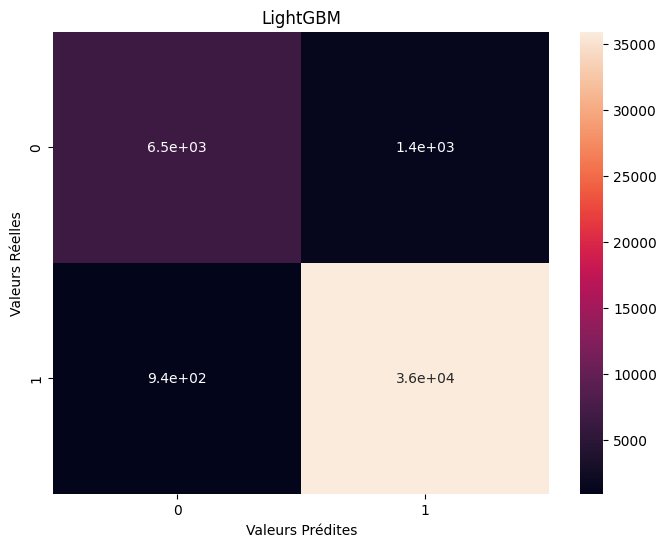

In [103]:
if grid_search_bool == True:
    plt.figure(figsize=(8, 6))
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    sns.heatmap(cm_lgbm, annot=True)
    plt.title("LightGBM")
    plt.xlabel('Valeurs Prédites')
    plt.ylabel('Valeurs Réelles')

    ################
    #SUMMARY
    report = classification_report(y_test, y_pred_lgbm, output_dict=True)
    df_report = pd.DataFrame(report)
    print("#########################################################")
    # Afficher les meilleurs paramètres
    print("Best Parameters:", grid_search.best_params_)
    print(f'Accuracy: {accuracy}')
    print(f'Grid Search Execution Time: {execution_time_grid_search}')
    print("#########################################################")
    print("     LGBM execution time is: ", execution_time_lgbm)
    print("#########################################################")
    print(df_report.T)
    print("#########################################################")
    print("                  F1 macro score:", round(report["macro avg"]["f1-score"], 4))
    print("#########################################################")